_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-17 01:16:23Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.36.0

sklearn: 1.6.1

pandas    : 2.2.3
scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 2.2.5
matplotlib: 3.10.3

Watermark: 2.5.0



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions (=stimulus directions)
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [34]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]  # this is the condition
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

C:\Users\janni\AppData\Local\Temp\ipykernel_13212\266504518.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [35]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


C:\Users\janni\AppData\Local\Temp\ipykernel_13212\3667823148.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuron_spikes["y"] = neuron_spikes.apply(
C:\Users\janni\AppData\Local\Temp\ipykernel_13212\3667823148.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


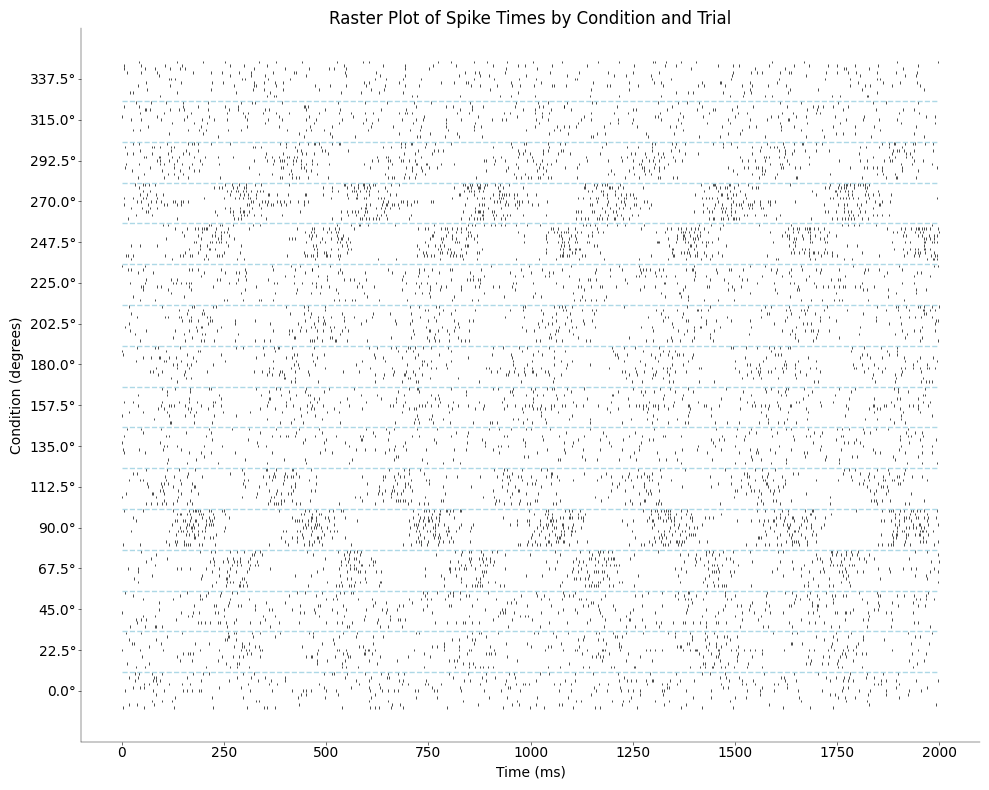

In [36]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    neuron_spikes = spikes[spikes["Neuron"] == neuron]

    conditions = sorted(neuron_spikes["Dir"].unique())
    max_trials = max(
        neuron_spikes[neuron_spikes["Dir"] == cond]["Trial"].nunique()
        for cond in conditions
    )
    y_base = {cond: i * (max_trials + 1) for i, cond in enumerate(conditions)}

    trial_positions = {
        cond: {
            trial: idx + 1
            for idx, trial in enumerate(
                sorted(neuron_spikes[neuron_spikes["Dir"] == cond]["Trial"].unique())
            )
        }
        for cond in conditions
    }
    neuron_spikes["y"] = neuron_spikes.apply(
        lambda row: y_base[row["Dir"]] + trial_positions[row["Dir"]][row["Trial"]],
        axis=1,
    )

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw spikes as small vertical lines
    line_height = 0.4
    ax.vlines(
        neuron_spikes["relTime"],
        neuron_spikes["y"] - line_height,
        neuron_spikes["y"] + line_height,
        color="black",
        linewidth=0.5,
    )

    # Draw horizontal separators between conditions
    for cond in conditions[1:]:
        sep_y = y_base[cond] - 0.5
        ax.hlines(
            sep_y,
            xmin=neuron_spikes["relTime"].min(),
            xmax=neuron_spikes["relTime"].max(),
            color="lightblue",
            linestyle="--",
        )

    # Customize axes
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Condition (degrees)")
    yticks = [
        y_base[cond] + (len(trial_positions[cond]) + 1) / 2 for cond in conditions
    ]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{cond}°" for cond in conditions])
    ax.set_title("Raster Plot of Spike Times by Condition and Trial")
    plt.tight_layout()
    plt.show()


plotRaster(spikes, 33)

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

In [37]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


C:\Users\janni\AppData\Local\Temp\ipykernel_13212\2873924455.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


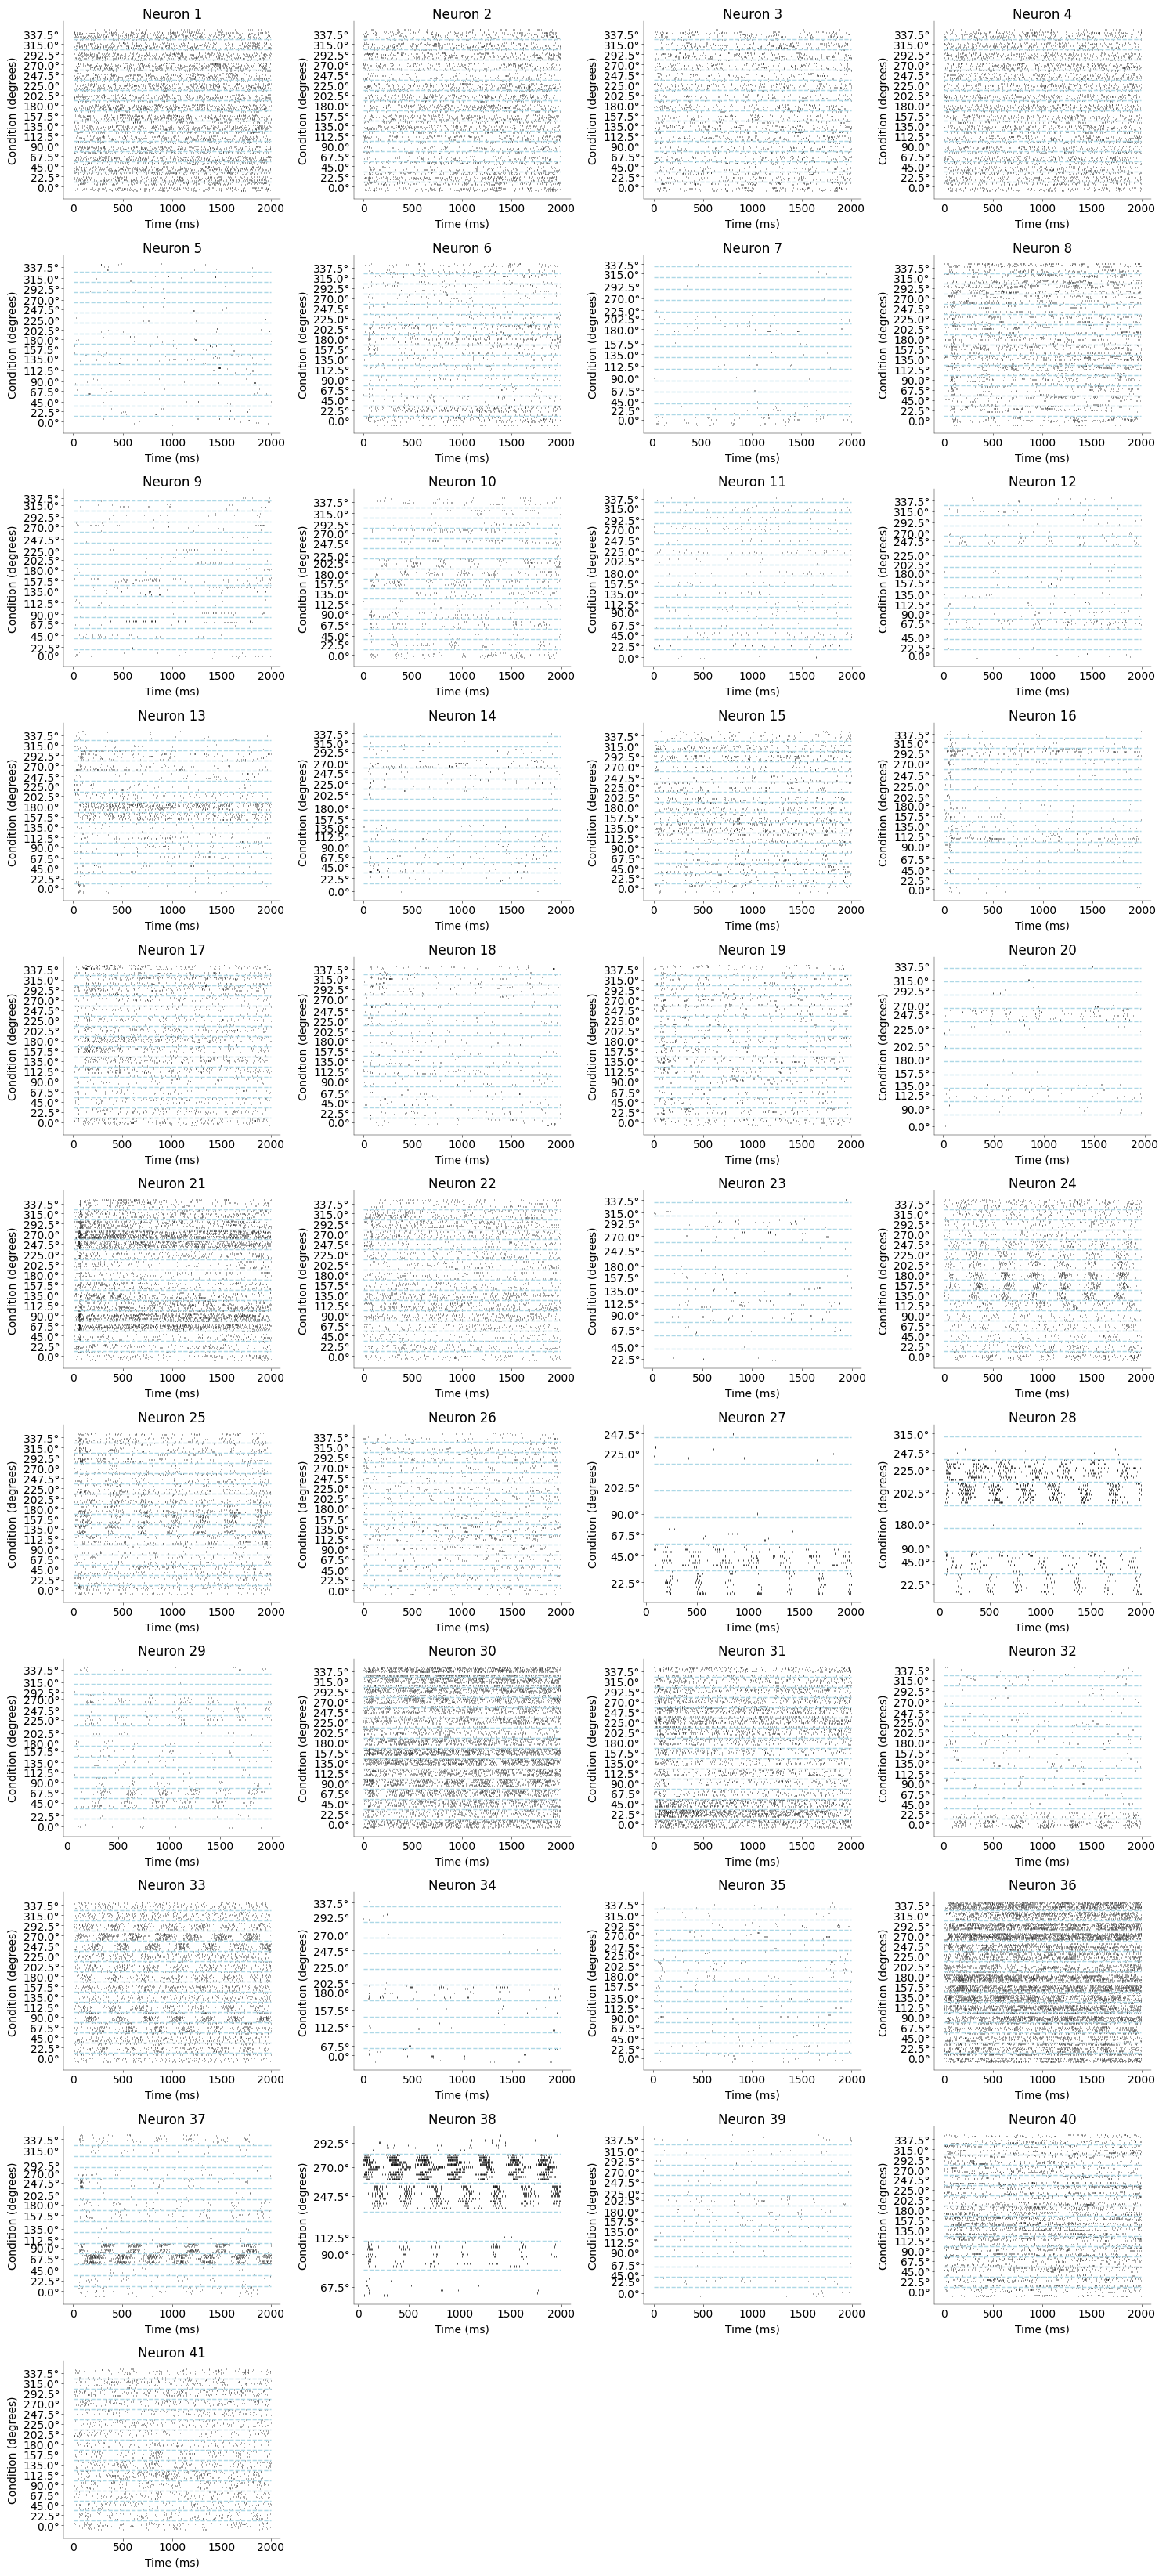

In [38]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------

# Plot raster plots for all neurons in a grid using the provided axes array
n_cols = 4
n_rows = int(np.ceil(len(spikes["Neuron"].unique()) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

neuron_ids = np.sort(spikes["Neuron"].unique())
for i, neuron_id in enumerate(neuron_ids):
    neuron_spikes = spikes[spikes["Neuron"] == neuron_id]

    conditions = sorted(neuron_spikes["Dir"].unique())
    max_trials = max(
        neuron_spikes[neuron_spikes["Dir"] == cond]["Trial"].nunique()
        for cond in conditions
    )
    y_base = {cond: j * (max_trials + 1) for j, cond in enumerate(conditions)}

    trial_positions = {
        cond: {
            trial: idx + 1
            for idx, trial in enumerate(
                sorted(neuron_spikes[neuron_spikes["Dir"] == cond]["Trial"].unique())
            )
        }
        for cond in conditions
    }
    neuron_spikes = neuron_spikes.copy()
    neuron_spikes["y"] = neuron_spikes.apply(
        lambda row: y_base[row["Dir"]] + trial_positions[row["Dir"]][row["Trial"]],
        axis=1,
    )

    ax = axes[i]

    line_height = 0.4
    ax.vlines(
        neuron_spikes["relTime"],
        neuron_spikes["y"] - line_height,
        neuron_spikes["y"] + line_height,
        color="black",
        linewidth=0.5,
    )

    for cond in conditions[1:]:
        sep_y = y_base[cond] - 0.5
        ax.hlines(
            sep_y,
            xmin=neuron_spikes["relTime"].min(),
            xmax=neuron_spikes["relTime"].max(),
            color="lightblue",
            linestyle="--",
        )

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Condition (degrees)")
    yticks = [
        y_base[cond] + (len(trial_positions[cond]) + 1) / 2 for cond in conditions
    ]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{cond}°" for cond in conditions])
    ax.set_title(f"Neuron {neuron_id}")

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Example explanations (to be filled in by student):
# 1. Neuron X: Direction selective because spikes occur only for one direction.
# 2. Neuron Y: Orientation selective because spikes occur for two opposite directions.
# 3. Neuron Z: Neither, as spikes are distributed across all directions.

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [39]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Implement one of the spike rate estimates (3 pts)
    # -------------------------------------------------

    for row, dir in enumerate(dirs):
        # ---------------------------------------------
        # Plot the obtained spike rate estimates (1 pt)
        # ---------------------------------------------
        continue

Plot the same 3 examples you selected in Task 1

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [ ]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    # we get the input in degrees, but the task defines the function assuming radians
    θ = np.deg2rad(θ)
    f = np.exp(α + κ * (np.cos(2 * (θ - ϕ)) - 1) + ν * (np.cos(θ - ϕ) - 1))
    return f

Plot the von Mises function while varying the parameters systematically.

C:\Users\janni\AppData\Local\Temp\ipykernel_13212\2998189196.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


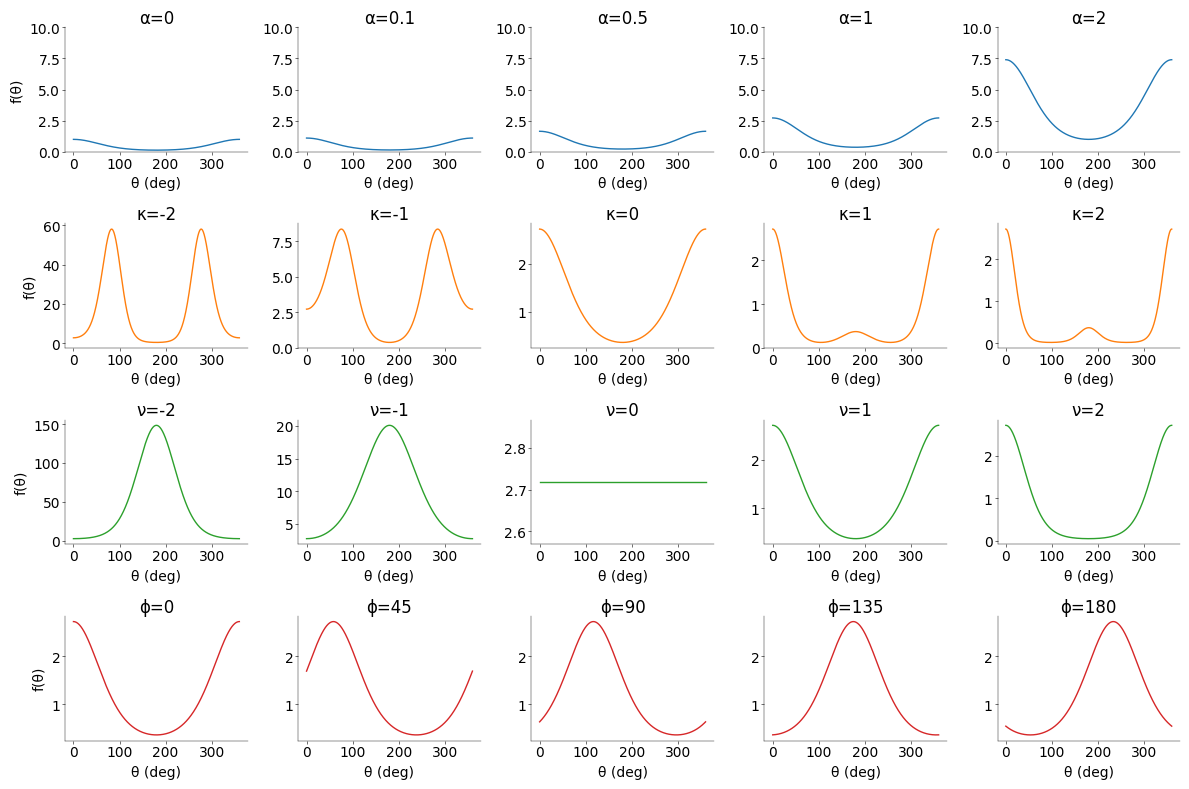

In [ ]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------

fig, ax = plt.subplots(4, 5, figsize=(12, 8))
angles = np.linspace(0, 360, 1000)  # in degrees
# each row varies one parameter:
alphas = [0, 0.1, 0.5, 1, 2]
kappas = [-2, -1, 0, 1, 2]
nus = [-2, -1, 0, 1, 2]
phis = [0, 45, 90, 135, 180]
# standard parameters to be used for the non-varying parameters:
standard_alpha = 1.0
standard_kappa = 0
standard_nu = 1.0
standard_phi = 0.0

# Vary α (row 0)
for i, α in enumerate(alphas):
    ax[0, i].plot(
        angles,
        vonMises(angles, α, standard_kappa, standard_nu, standard_phi),
        color="C0",
    )
    ax[0, i].set_title(f"α={α}")
    ax[0, i].set_xlabel("θ (deg)")
    if i == 0:
        ax[0, i].set_ylabel("f(θ)")
    ax[0, i].set_ylim(0, 10)

# Vary κ (row 1)
for i, κ in enumerate(kappas):
    ax[1, i].plot(
        angles,
        vonMises(angles, standard_alpha, κ, standard_nu, standard_phi),
        color="C1",
    )
    ax[1, i].set_title(f"κ={κ}")
    ax[1, i].set_xlabel("θ (deg)")
    if i == 0:
        ax[1, i].set_ylabel("f(θ)")

# Vary ν (row 2)
for i, ν in enumerate(nus):
    ax[2, i].plot(
        angles,
        vonMises(angles, standard_alpha, standard_kappa, ν, standard_phi),
        color="C2",
    )
    ax[2, i].set_title(f"ν={ν}")
    ax[2, i].set_xlabel("θ (deg)")
    if i == 0:
        ax[2, i].set_ylabel("f(θ)")

# Vary ϕ (row 3)
for i, ϕ in enumerate(phis):
    ax[3, i].plot(
        angles,
        vonMises(angles, standard_alpha, standard_kappa, standard_nu, ϕ),
        color="C3",
    )
    ax[3, i].set_title(f"ϕ={ϕ}")
    ax[3, i].set_xlabel("θ (deg)")
    if i == 0:
        ax[3, i].set_ylabel("f(θ)")

plt.tight_layout()
plt.show()

Oberservations:
- $\alpha$ scales the function (you can essentially pull out $exp(\alpha)$ to the fron of the equation)
- $\kappa$ adds a periodic component with frequency of 2-cycles per 360 degrees
- $\nu$ adds a periodic component with frequency of 1-cycle per 360 degrees
- $\phi$ phase shifts the function to the left or right

In [ ]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------
    # NOTE here the list of counts is used to generate the matrix and indexed by the dirs
    # I didnt quite get why the spikes are not passed to the function (if the task says something about gropby on a DataFrame)
    matrix = np.zeros((nTrials, nDirs))
    for i in range(1, nTrials + 1):
        for j in range(nDirs):
            matrix[i - 1, j] = counts[(i - 1) * nDirs + j]

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------
    def fit_func(x, α, κ, ν, ϕ):
        return vonMises(x, α, κ, ν, ϕ)

    p0 = [1.0, 1.0, 1.0, 0.0]  # initial guess
    bounds = (-1, np.inf)  # bounds for the parameters
    p, _ = opt.curve_fit(
        fit_func,
        dirs,
        matrix.flatten(),
        p0=p0,
        bounds=bounds,
    )
    # p = [α, κ, ν, ϕ]

    if show:
        # --------------------------------------------
        # plot the data and fitted tuning curve (1 pt)
        # --------------------------------------------
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title(f"Tuning curve for neuron {neuron}")
        ax.set_xlabel("Direction (deg)")
        ax.set_ylabel("Spike count")
        ax.set_xlim(0, 360)
        ax.plot(dirs, matrix.flatten(), "o", label="Data")
        ax.plot(
            dirs,
            vonMises(dirs, *p),
            label="Fitted tuning curve",
            color="red",
        )
        ax.legend()
        plt.show()

    return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [102]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()  # this counts the TRUE values aka how many spikes there are
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:

            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

C:\Users\janni\AppData\Local\Temp\ipykernel_13212\1603573077.py:74: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


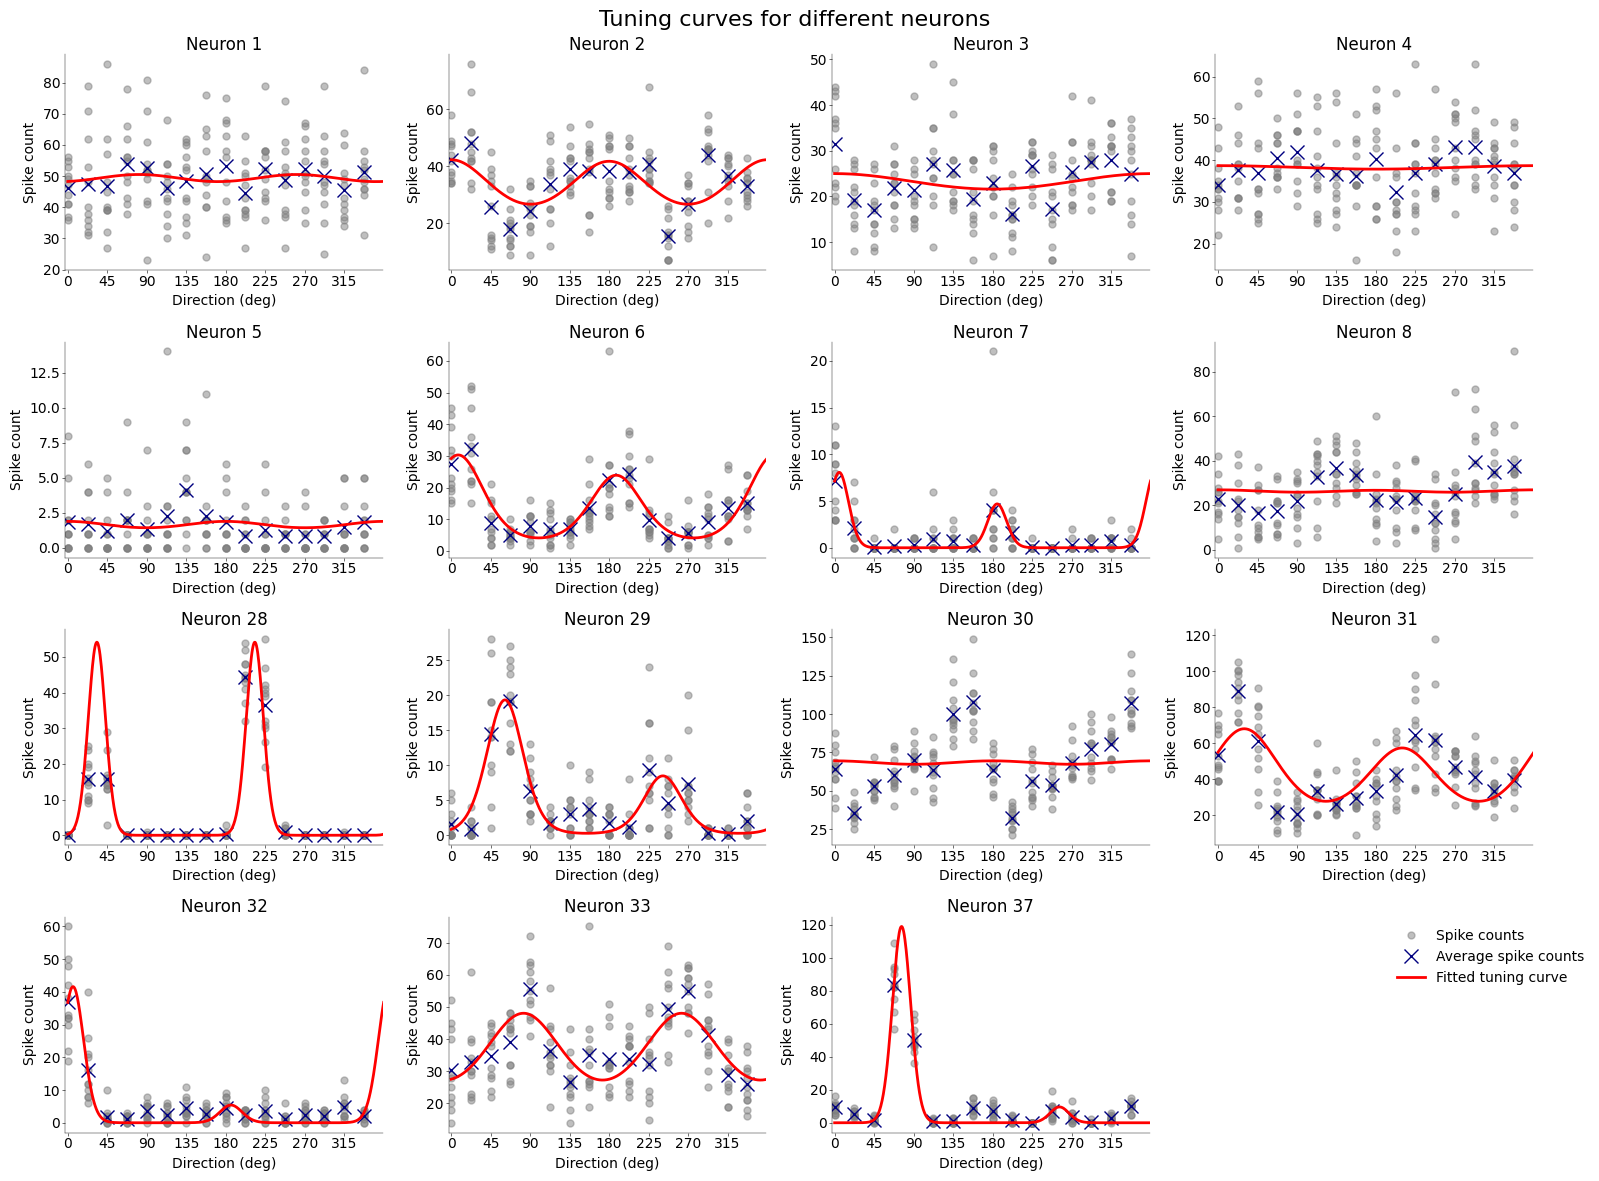

In [103]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------

neurons = [1, 2, 3, 4, 5, 6, 7, 8, 28, 29, 30, 31, 32, 33, 37]
directions = np.unique(spikes["Dir"])
w = 4
h = int(np.ceil(len(neurons) / w))
fig, axs = plt.subplots(h, w, figsize=(w * 4, h * 3))
axs = axs.flatten()
for i, neuron in enumerate(neurons):
    ax = axs[i]
    dirs_sorted, counts_sorted = get_data(spikes, neuron)
    ax.set_title(f"Neuron {neuron}")

    # plot the spike counts from individual trials
    ax.plot(
        dirs_sorted,
        counts_sorted,
        "o",
        label="Spike counts",
        color="grey",
        markersize=5,
        alpha=0.5,
    )
    ax.set_xlabel("Direction (deg)")
    ax.set_ylabel("Spike count")
    ax.set_xlim(-3, 359)
    ax.set_xticks(np.arange(0, 359, 45))

    # plot the average number of spikes per direction
    avg_counts = np.zeros(nDirs)
    for i in range(nDirs):
        avg_counts[i] = np.mean(counts_sorted[dirs_sorted == directions[i]])
    ax.plot(
        directions,
        avg_counts,
        "x",
        label="Average spike counts",
        color="navy",
        markersize=10,
    )

    # plot the tuning curve
    # Fit the tuning curve using the tuningCurve function
    p = tuningCurve(counts_sorted, dirs_sorted, show=False)
    fit_angles = np.linspace(0, 360, 500)
    ax.plot(
        fit_angles,
        vonMises(fit_angles, *p),
        label="Fitted tuning curve",
        color="red",
        linewidth=2,
    )

# legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_pos = len(neurons) if len(neurons) % w != 0 else len(neurons) - 1
axs[legend_pos].legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    bbox_to_anchor=(1.2, 1),
    fontsize=10,
)
# Hide unused axes if any
for j in range(len(neurons), len(axs)):
    axs[j].axis("off")

plt.suptitle("Tuning curves for different neurons", fontsize=16)
plt.tight_layout()
plt.show()

Observations:
- neuron 28 and neuron 31 are good examples where the function fits nicely
- for neuron 37 we see that the main peak is fitted nicely, but the activity pattern seems to have a period of 4 (three littel bumps) that we cannot fit with the von Mises function
- there are also cases like neuron 8 and neuron 30, we it looks like we could have found a better fit than what actually was found

In [ ]:
## Small comparison of using groupby and the mathod based on arguments passed to the function:

dirs, counts = get_data(spikes, 30)
matrix = np.zeros((nTrials, nDirs))
for i in range(1, nTrials + 1):
    for j in range(nDirs):
        matrix[i - 1, j] = counts[(i - 1) * nDirs + j]

# generate the same based on spikes and groupby
spk_by_dir = (
    spikes[spikes["Neuron"] == 30]
    .groupby(["Dir", "Trial"])["stimPeriod"]
    .sum()
    .astype(int)
    .reset_index()
)
# check if the two methods agree
if np.array_equal(spk_by_dir["stimPeriod"].values, matrix.flatten()):
    print("Both methods agree")

Both methods agree


## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [47]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    if show:
        # add plotting code here
        pass

Show null distribution for the example cell:

In [48]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------

Test all cells for orientation and direction tuning

In [49]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------

Number of direction tuned neurons:

Number of orientation tuned neurons: